In [1]:
import os, sys
import glob

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib
import xarray as xr
import pandas as pd

#os.environ['CUDA_VISIBLE_DEVICES'] = '3'


matplotlib.rc('text', usetex=True)

import seaborn as sns

sns.set(style="whitegrid")
sns.set_context("paper", font_scale=2.5)
sys.path.append('../')

import geonexl1b
import models
from models import SplitAutoEncoder, SplitGenVAE

import utils
from inference import domain_to_domain, load_model

import dask as da

import torchvision.utils

## Set Model

In [2]:
threesat_config = '/nobackupp10/tvandal/nex-ai-geo-translation/configs/Base-G16G17H8.yaml'
#threesat_config = '/nobackupp10/tvandal/nex-ai-geo-translation/configs/Larger-G16G17H8.yaml'
twosat_config = '/nobackupp10/tvandal/nex-ai-geo-translation/configs/Base-G16G17.yaml'

twosat_model, twosat_params = load_model(twosat_config)
threesat_model, threesat_params = load_model(threesat_config)

abi_overlap = [0,1,2] + list(range(4,16))
ahi_overlap = [0] + list(range(2,16))

../utils.py:72: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)


Loaded model from step: 199001
Loaded model from step: 199001


## Get Data

In [3]:
goespaired = geonexl1b.L1bPaired('../data/Test/GOES16/GEONEX-L1B/', 
                                 '../data/Test/GOES17/GEONEX-L1B/',
                                 'G16', 'G17')
paired_tiles = goespaired.tiles()
goes_files = goespaired.files(cachedir='tmp').reset_index()
#goes_files = goes_files.head(50)
goes_files

,timestamp,tile,year1,dayofyear1,hour1,minute1,file1,h1,v1,year2,dayofyear2,hour2,minute2,file2,h2,v2
0,20190101_2000,h09v01,2019,1,20,0,../data/Test/GOES16/GEONEX-L1B/h09v01/2019/001...,9,1,2019,1,20,0,../data/Test/GOES17/GEONEX-L1B/h09v01/2019/001...,9,1
1,20190101_2000,h12v05,2019,1,20,0,../data/Test/GOES16/GEONEX-L1B/h12v05/2019/001...,12,5,2019,1,20,0,../data/Test/GOES17/GEONEX-L1B/h12v05/2019/001...,12,5
2,20190101_2000,h14v06,2019,1,20,0,../data/Test/GOES16/GEONEX-L1B/h14v06/2019/001...,14,6,2019,1,20,0,../data/Test/GOES17/GEONEX-L1B/h14v06/2019/001...,14,6
3,20190101_2000,h10v03,2019,1,20,0,../data/Test/GOES16/GEONEX-L1B/h10v03/2019/001...,10,3,2019,1,20,0,../data/Test/GOES17/GEONEX-L1B/h10v03/2019/001...,10,3
4,20190101_2000,h11v05,2019,1,20,0,../data/Test/GOES16/GEONEX-L1B/h11v05/2019/001...,11,5,2019,1,20,0,../data/Test/GOES17/GEONEX-L1B/h11v05/2019/001...,11,5
5,20190101_2000,h13v01,2019,1,20,0,../data/Test/GOES16/GEONEX-L1B/h13v01/2019/001...,13,1,2019,1,20,0,../data/Test/GOES17/GEONEX-L1B/h13v01/2019/001...,13,1
6,20190101_2000,h14v07,2019,1,20,0,../data/Test/GOES16/GEONEX-L1B/h14v07/2019/001...,14,7,2019,1,20,0,../data/Test/GOES17/GEONEX-L1B/h14v07/2019/001...,14,7
7,20190101_2000,h16v17,2019,1,20,0,../data/Test/GOES16/GEONEX-L1B/h16v17/2019/001...,16,17,2019,1,20,0,../data/Test/GOES17/GEONEX-L1B/h16v17/2019/001...,16,17
8,20190101_2000,h10v04,2019,1,20,0,../data/Test/GOES16/GEONEX-L1B/h10v04/2019/001...,10,4,2019,1,20,0,../data/Test/GOES17/GEONEX-L1B/h10v04/2019/001...,10,4
9,20190101_2000,h13v05,2019,1,20,0,../data/Test/GOES16/GEONEX-L1B/h13v05/2019/001...,13,5,2019,1,20,0,../data/Test/GOES17/GEONEX-L1B/h13v05/2019/001...,13,5


In [4]:
load = lambda f: geonexl1b.L1bFile(f).load()[np.newaxis]
g16_data = np.vstack(goes_files['file1'].map(load))
g17_data = np.vstack(goes_files['file2'].map(load))

In [5]:
goes_files['h'] = goes_files['tile'].map(lambda x: int(x[1:3]))
goes_files['v'] = goes_files['tile'].map(lambda x: int(x[4:6]))
pivotfiles = goes_files.pivot('v', 'h', 'file1')
pivotfiles

h,8,9,10,11,12,13,14,15,16
v,,,,,,,,,
1,../data/Test/GOES16/GEONEX-L1B/h08v01/2019/001...,../data/Test/GOES16/GEONEX-L1B/h09v01/2019/001...,../data/Test/GOES16/GEONEX-L1B/h10v01/2019/001...,../data/Test/GOES16/GEONEX-L1B/h11v01/2019/001...,../data/Test/GOES16/GEONEX-L1B/h12v01/2019/001...,../data/Test/GOES16/GEONEX-L1B/h13v01/2019/001...,../data/Test/GOES16/GEONEX-L1B/h14v01/2019/001...,../data/Test/GOES16/GEONEX-L1B/h15v01/2019/001...,NaN
2,NaN,../data/Test/GOES16/GEONEX-L1B/h09v02/2019/001...,../data/Test/GOES16/GEONEX-L1B/h10v02/2019/001...,../data/Test/GOES16/GEONEX-L1B/h11v02/2019/001...,../data/Test/GOES16/GEONEX-L1B/h12v02/2019/001...,../data/Test/GOES16/GEONEX-L1B/h13v02/2019/001...,../data/Test/GOES16/GEONEX-L1B/h14v02/2019/001...,../data/Test/GOES16/GEONEX-L1B/h15v02/2019/001...,NaN
3,NaN,../data/Test/GOES16/GEONEX-L1B/h09v03/2019/001...,../data/Test/GOES16/GEONEX-L1B/h10v03/2019/001...,../data/Test/GOES16/GEONEX-L1B/h11v03/2019/001...,../data/Test/GOES16/GEONEX-L1B/h12v03/2019/001...,../data/Test/GOES16/GEONEX-L1B/h13v03/2019/001...,../data/Test/GOES16/GEONEX-L1B/h14v03/2019/001...,../data/Test/GOES16/GEONEX-L1B/h15v03/2019/001...,NaN
4,NaN,../data/Test/GOES16/GEONEX-L1B/h09v04/2019/001...,../data/Test/GOES16/GEONEX-L1B/h10v04/2019/001...,../data/Test/GOES16/GEONEX-L1B/h11v04/2019/001...,../data/Test/GOES16/GEONEX-L1B/h12v04/2019/001...,../data/Test/GOES16/GEONEX-L1B/h13v04/2019/001...,../data/Test/GOES16/GEONEX-L1B/h14v04/2019/001...,../data/Test/GOES16/GEONEX-L1B/h15v04/2019/001...,NaN
5,NaN,NaN,../data/Test/GOES16/GEONEX-L1B/h10v05/2019/001...,../data/Test/GOES16/GEONEX-L1B/h11v05/2019/001...,../data/Test/GOES16/GEONEX-L1B/h12v05/2019/001...,../data/Test/GOES16/GEONEX-L1B/h13v05/2019/001...,../data/Test/GOES16/GEONEX-L1B/h14v05/2019/001...,../data/Test/GOES16/GEONEX-L1B/h15v05/2019/001...,../data/Test/GOES16/GEONEX-L1B/h16v05/2019/001...
6,NaN,NaN,NaN,../data/Test/GOES16/GEONEX-L1B/h11v06/2019/001...,../data/Test/GOES16/GEONEX-L1B/h12v06/2019/001...,../data/Test/GOES16/GEONEX-L1B/h13v06/2019/001...,../data/Test/GOES16/GEONEX-L1B/h14v06/2019/001...,../data/Test/GOES16/GEONEX-L1B/h15v06/2019/001...,../data/Test/GOES16/GEONEX-L1B/h16v06/2019/001...
7,NaN,NaN,NaN,NaN,../data/Test/GOES16/GEONEX-L1B/h12v07/2019/001...,../data/Test/GOES16/GEONEX-L1B/h13v07/2019/001...,../data/Test/GOES16/GEONEX-L1B/h14v07/2019/001...,../data/Test/GOES16/GEONEX-L1B/h15v07/2019/001...,../data/Test/GOES16/GEONEX-L1B/h16v07/2019/001...
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,../data/Test/GOES16/GEONEX-L1B/h16v08/2019/001...
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,../data/Test/GOES16/GEONEX-L1B/h16v09/2019/001...


In [6]:
hsize = pivotfiles.shape[1]
vsize = pivotfiles.shape[0]

size = 600
data = np.empty((vsize*size, hsize*size, 16))
for ih in range(hsize):
    for iv in range(vsize):
        f = pivotfiles.values[iv, ih]
        if isinstance(f, str):
            data[iv*size:(iv+1)*size, ih*size:(ih+1)*size] = geonexl1b.L1bFile(f, resolution_km=1.).load()

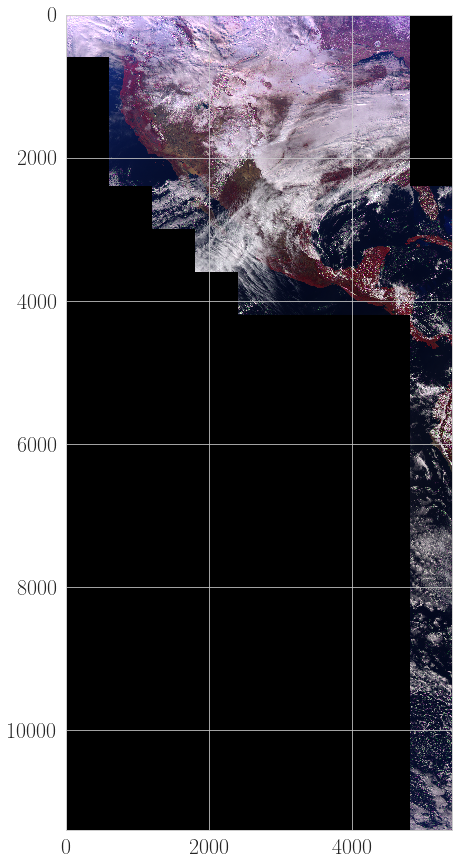

In [7]:
fig, axs = plt.subplots(1,1,figsize=(15,15))
axs.imshow(data[:,:,[2,1,0]])
plt.show()

#save_image(data[:,:,[2,1,0]],'figures/rgb_observed.png')

In [8]:
make_prediction = lambda d: domain_to_domain(twosat_model, d, 'G16', 'G17')[np.newaxis]
twosat_g17_prediction = np.vstack([make_prediction(x) for x in g16_data])
twosat_g17_prediction[np.isinf(twosat_g17_prediction)] = np.nan
twosat_g17_prediction.shape

(59, 300, 300, 16)

In [9]:
make_prediction = lambda d: domain_to_domain(threesat_model, d, 'G16', 'G17')[np.newaxis]
threesat_g17_prediction = np.vstack([make_prediction(x) for x in g16_data])
threesat_g17_prediction[np.isinf(threesat_g17_prediction)] = np.nan
threesat_g17_prediction.shape

(59, 300, 300, 16)

In [10]:
experiment_dir = '/nobackupp10/tvandal/nex-ai-geo-translation/experiments/1/drop_individual_G16/'
exp_names = ['Band%i' % i for i in range(0,16)]

synthetic_prediction = np.empty_like(g16_data)

for i in range(0,16):
    name = 'Band%i' % i
    config_path = os.path.join(experiment_dir, name, 'params.yaml')
    model, params = load_model(config_path)
    input_channels = list(range(0,i)) + list(range(i+1,16))
    
    make_prediction = lambda d: domain_to_domain(model, d, 'G16', 'G17', bands1=input_channels)[np.newaxis,:,:,i]
    synthetic_prediction[:,:,:,i] = np.vstack([make_prediction(x) for x in g16_data])    

../utils.py:72: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  return yaml.load(f)


Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000
Loaded model from step: 200000


In [11]:
rmse_func = lambda x, y: np.nanmean((x - y)**2, axis=(0,1,2))**0.5

def psnr16(x, y):
    mse = np.nanmean((x-y)**2, axis=(1,2))
    refl_width = 1.6
    rad_width = 350-150
    #rad_width = 275-190
    
    psnr = np.zeros_like(mse)
    psnr[:,:6] = 10 * np.log10(refl_width**2 / mse[:,:6])
    psnr[:,6:] = 10 * np.log10(rad_width**2 / mse[:,6:])
    return psnr


twosat_rmse = rmse_func(twosat_g17_prediction, g16_data)
threesat_rmse = rmse_func(threesat_g17_prediction, g16_data)

stats = pd.DataFrame({"Two Sat Reconstruction": twosat_rmse,
                      "Three Sat Reconstruction": threesat_rmse,
                      "Band": list(range(1,17))}).set_index('Band')
stats

,Two Sat Reconstruction,Three Sat Reconstruction
Band,,
1,0.052575,0.057610
2,0.067526,0.064402
3,0.068880,0.074928
4,0.012420,0.014066
5,0.051748,0.054839
6,0.042509,0.047508
7,1.251278,1.392526
8,0.554984,0.662518
9,0.660491,0.650743


      index  sample  Band       PSNR        Group
0         0       0     1  22.424542       Sensor
1         1       0     2  19.727697       Sensor
2         2       0     3  19.997941       Sensor
3         3       0     4  25.124449       Sensor
4         4       0     5  21.789953       Sensor
...     ...     ...   ...        ...          ...
2827   2827      58    12  45.365698  Reconstruct
2828   2828      58    13  40.764273  Reconstruct
2829   2829      58    14  42.705142  Reconstruct
2830   2830      58    15  45.152350  Reconstruct
2831   2831      58    16  40.598968  Reconstruct

[2832 rows x 5 columns]


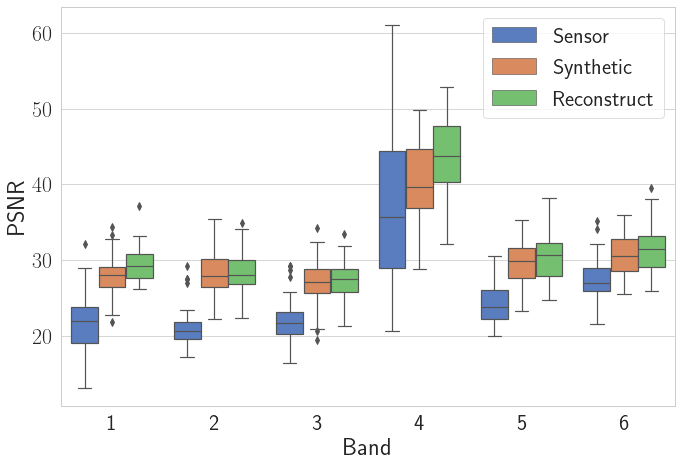

In [12]:
twosat_psnr = psnr16(twosat_g17_prediction, g16_data)
threesat_psnr = psnr16(threesat_g17_prediction, g16_data)
synth_psnr = psnr16(synthetic_prediction, g16_data)

sensor_psnr = psnr16(g16_data, g17_data)

df1 = xr.DataArray(sensor_psnr, dims=['sample', 'Band'], coords=dict(Band=list(range(1,17))), name='PSNR').to_dataframe()
df2 = xr.DataArray(threesat_psnr, dims=['sample', 'Band'], coords=dict(Band=list(range(1,17))), name='PSNR').to_dataframe()
df3 = xr.DataArray(synth_psnr, dims=['sample', 'Band'], coords=dict(Band=list(range(1,17))), name='PSNR').to_dataframe()

df1['Group'] = 'Sensor'
df2['Group'] = 'Reconstruct'
df3['Group'] = 'Synthetic'

df = pd.concat([df1, df3, df2], axis=0).reset_index()

print(df.reset_index())
f, axs = plt.subplots(1,1,figsize=(10,7))
axs = np.ravel(axs)
df_refl = df[df['Band'] <= 6]
sns.boxplot(x='Band', y='PSNR', data=df_refl, hue='Group', ax=axs[0], palette='muted')
axs[0].legend(loc=1)
plt.tight_layout()
plt.savefig("figures/drop_individual_reflectances.png")
plt.show()

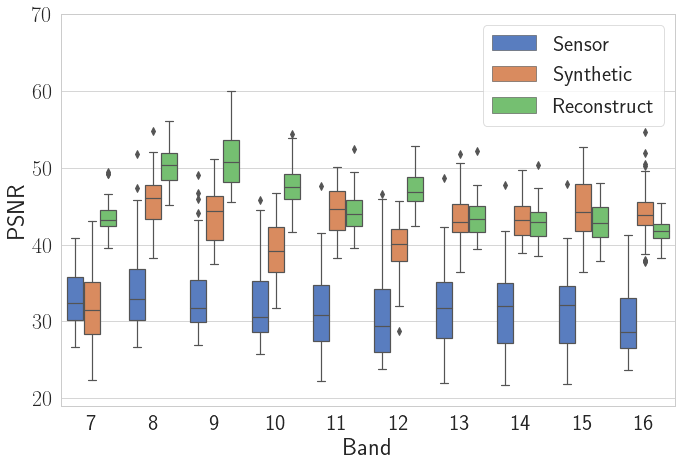

In [13]:
f, axs = plt.subplots(1,1,figsize=(10,7))
axs = np.ravel(axs)
df_tir = df[df['Band'] > 6]
sns.boxplot(x='Band', y='PSNR', data=df_tir, hue='Group', ax=axs[0], palette='muted')
axs[0].legend(loc=1)
axs[0].set_ylim([19, 70])
plt.tight_layout()
plt.savefig("figures/drop_individual_TIR.png")
plt.show()

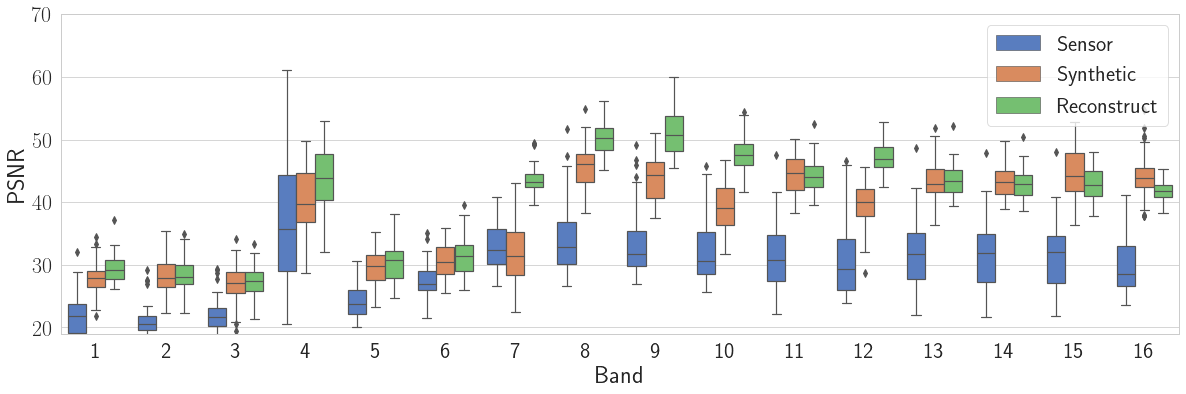

In [14]:
f, axs = plt.subplots(1,1,figsize=(17,6))
axs = np.ravel(axs)
sns.boxplot(x='Band', y='PSNR', data=df, hue='Group', ax=axs[0], palette='muted')
axs[0].legend(loc=1)
axs[0].set_ylim([19, 70])
plt.tight_layout()
plt.savefig("figures/drop_individual.png")
plt.savefig("figures/drop_individual.svg")
plt.show()

In [14]:
stats['Synthetic'] = rmse_func(synthetic_prediction, g16_data)

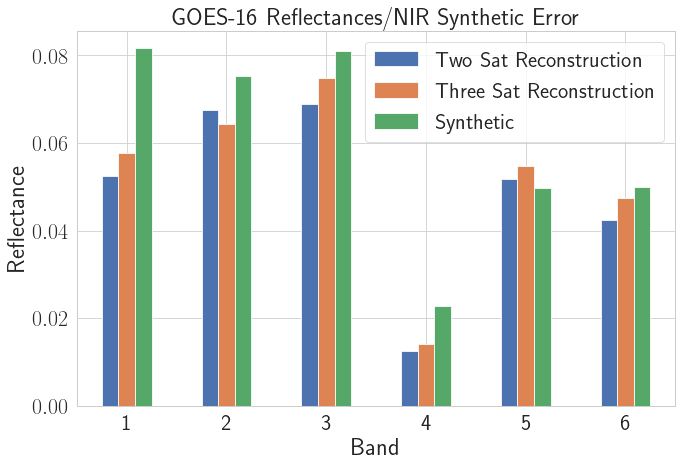

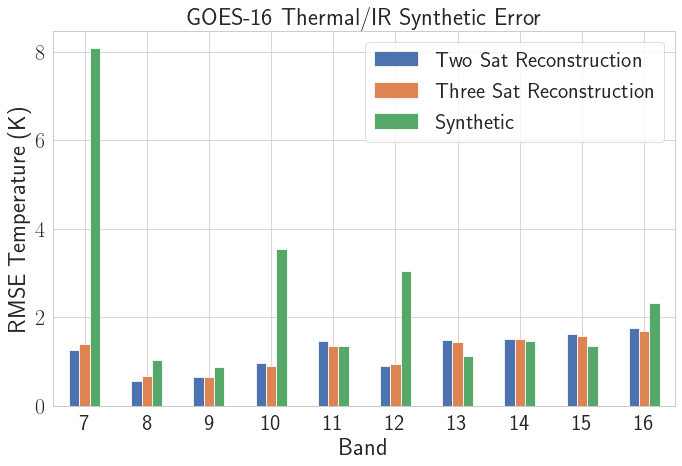

In [15]:
f, axs = plt.subplots(1,1,figsize=(10,7))
axs = np.ravel(axs)
stats.iloc[:6].plot.bar(rot=0, ax=axs[0])
axs[0].set_ylabel("Reflectance")
axs[0].set_title("GOES-16 Reflectances/NIR Synthetic Error")

plt.tight_layout()
plt.savefig("figures/drop_individual_reflectances.png")
plt.show()

f, axs = plt.subplots(1,1,figsize=(10,7))
axs = np.ravel(axs)
stats.iloc[6:].plot.bar(rot=0, ax=axs[0])
axs[0].set_ylabel("RMSE Temperature (K)")
axs[0].set_title("GOES-16 Thermal/IR Synthetic Error")
plt.tight_layout()
plt.savefig("figures/drop_individual_TIR.png")
plt.show()

In [ ]:
np.nanmin(g16_data[:,:,:,9]), np.nanmax(g16_data[:,:,:,9])